# Auto-encoders on Fashion MNIST dataset using infoGAN architecture 

## Bastien

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
#%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from keras.models import Model
from keras import losses, regularizers
from keras import backend as K
from keras import metrics

from vis.visualization import visualize_activation, visualize_activation_with_losses
from vis.regularizers import TotalVariation, LPNorm
from vis.losses import ActivationMaximization
from vis.input_modifiers import Jitter
                                                                   
sys.path.append('/home/bastien/Documents/StageCMM/Auto-encoders/')
from fashion_mnist.utils import mnist_reader
from keras.models import load_model

import h5py

sys.path.append('/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode')

from bastien_utils import load_AE

/home/bastien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
FILE_PATH = "../"

img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [3]:
x_train, y_train = mnist_reader.load_mnist(FILE_PATH + 'fashion_mnist/data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist(FILE_PATH + 'fashion_mnist/data/fashion', kind='t10k')


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


print('x_train shape:', x_train.shape)

print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [5]:
rand_int = np.random.randint(100)
x_test_small=np.array([x_test[y_test==i][rand_int] for i in range(10)])

In [21]:
from matplotlib import offsetbox

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 2e-4:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props=dict(boxstyle='round', edgecolor='white')
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(x_test[i,:,:,0], cmap=plt.cm.gray, zoom=1), X[i], bboxprops=props)
            ax.add_artist(imagebox)
    if title is not None:
        plt.title(title)

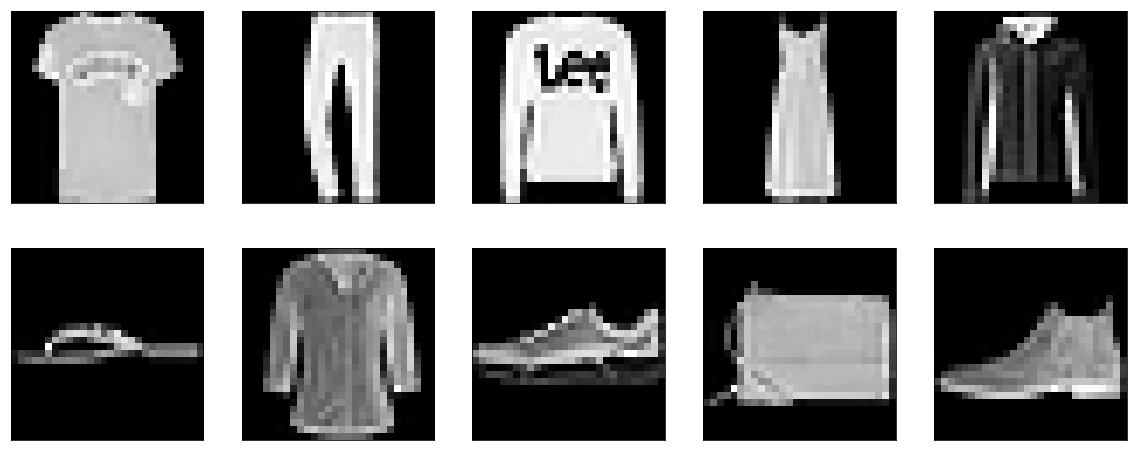

In [5]:
n = 5  
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img = x_test[y_test==i][0]
    plt.imshow(img[:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    img = x_test[y_test==i+5][0]
    plt.imshow(img[:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = 5  
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    img = x_test[y_test==i][0]
    plt.imshow(img[:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    img = x_test[y_test==i+5][0]
    plt.imshow(img[:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 1. Simple AE: No constraints

In [9]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(1024)(encoded_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(6272)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((7,7,128))(x)
x = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
decoded = Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', activation='sigmoid')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
__________

```python
t0 = time.time()

autoencoder.fit(x_train, x_train,
                epochs=50,
                verbose=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

t1 = time.time()

print("\n\t Training Time: ", t1-t0, " s \n")

```

### Latent dimension: 100

In [6]:
autoencoder, encoder, decoder = load_AE('./Models/AEisoGAN_100.h5')

In [7]:
autoencoder.evaluate(x_test, x_test)

10000/10000 [==============================] - 24s 2ms/step


0.2578085441112518

In [32]:
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

In [33]:
print('Code shape: ', H.shape)
print('Reconstruction shape: ', x_reconstruction_test.shape)

Code shape:  (10000, 100)
Reconstruction shape:  (10000, 28, 28, 1)


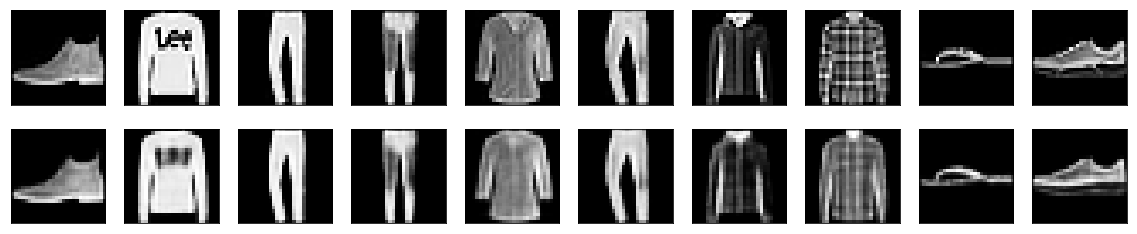

In [34]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstruction_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

### Latent Dimensions : 1 & 6

In [53]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEisoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')

OSError: Unable to open file (Unable to open file: name = '/home/bastien/documents/stagecmm/auto-encoders/aeisogan/simple/models/18_05_22_aeisogan_100.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [54]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                6570698   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         6601665   
Total params: 13,172,363
Trainable params: 13,155,339
Non-trainable params: 17,024
_________________________________________________________________


### 1.2 Comparing the reconstruction error for different code sizes

In [96]:
training_times_5_500 = np.load('../AEinfoGAN/Simple/TrainingOutputs/18_05_28_training_times_5_500_86.npy')
training_errors_5_500 = np.load('../AEinfoGAN/Simple/TrainingOutputs/18_05_28_training_errors_5_500_86.npy')
test_errors_5_500 = np.load('../AEinfoGAN/Simple/TrainingOutputs/18_05_28_test_errors_5_500_86.npy')
dimensions_5_500 = np.load('../AEinfoGAN/Simple/TrainingOutputs/18_05_28_dimensions_5_500_86.npy')

In [49]:
pd.DataFrame(data={'Dimension':dimensions_5_500, 'Training Time': training_times_5_500, 'Training Error':training_errors_5_500, 'Validation Error': test_errors_5_500})

,Dimension,Training Error,Training Time,Validation Error
0,5.0,0.282914,1031.354989,0.287785
1,10.0,0.268104,1065.880450,0.273691
2,15.0,0.263747,1143.368725,0.269305
3,20.0,0.261148,1191.065703,0.266432
4,25.0,0.259092,1608.827536,0.264168
5,30.0,0.257884,1556.758717,0.262865
6,35.0,0.257246,1237.903418,0.261953
7,40.0,0.256501,1240.841637,0.261147
8,45.0,0.255628,1230.139683,0.260164
9,50.0,0.255084,1218.900452,0.259564


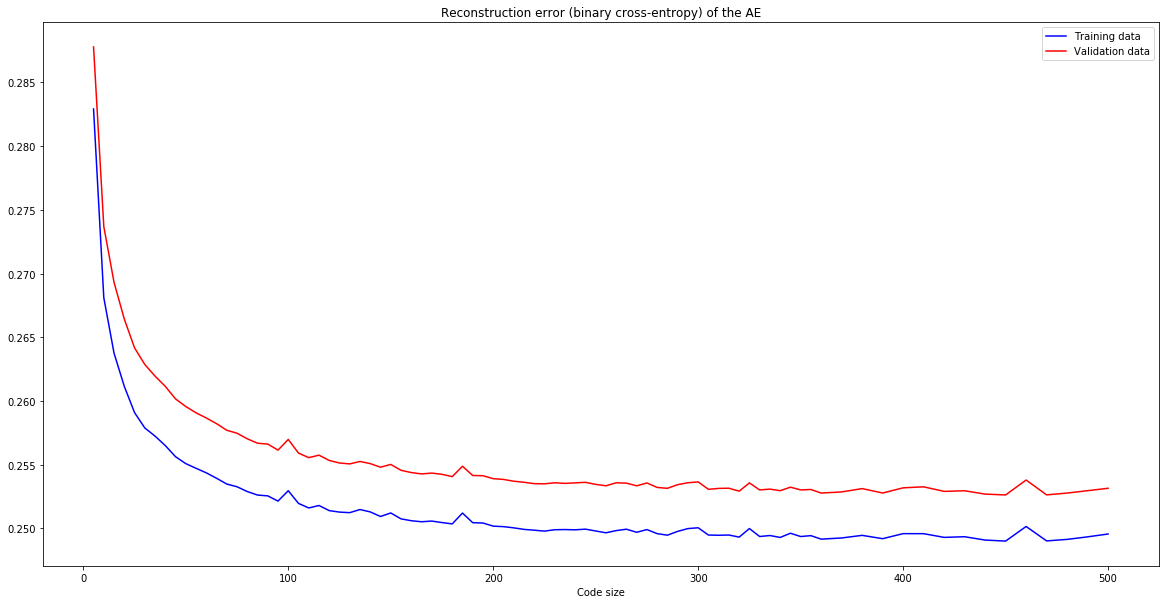

In [50]:
plt.figure(figsize=(20,10))
plt.plot(dimensions_5_500, training_errors_5_500, 'b')
plt.plot(dimensions_5_500, test_errors_5_500, 'r')
plt.legend(['Training data', 'Validation data'])
plt.xlabel('Code size')
plt.title('Reconstruction error (binary cross-entropy) of the AE')
plt.show()

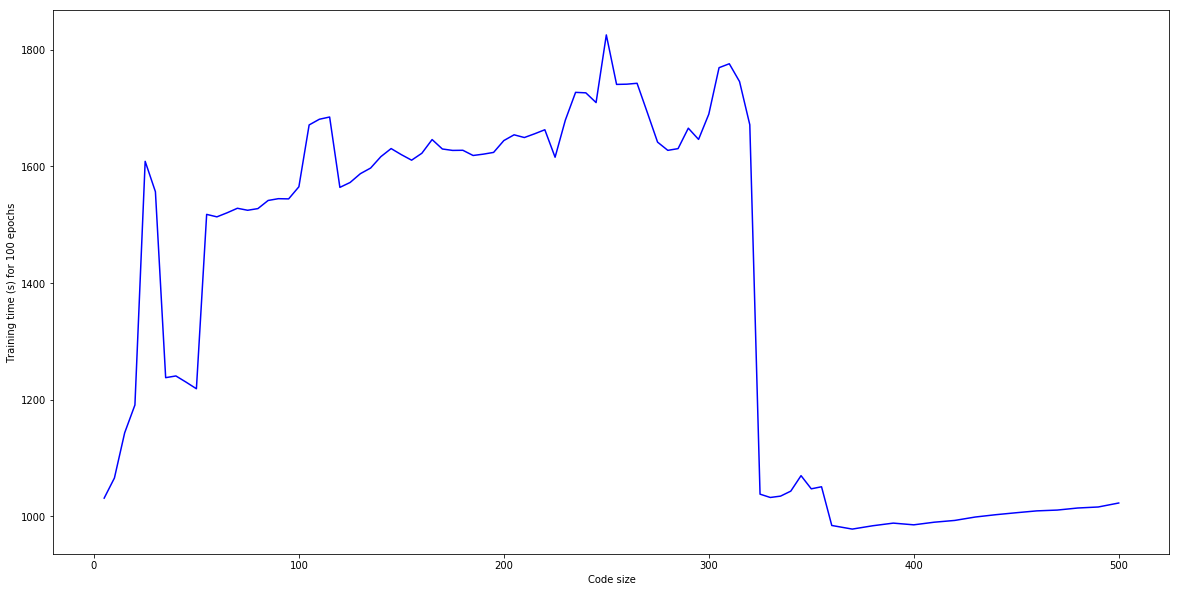

In [51]:
plt.figure(figsize=(20,10))
plt.plot(dimensions_5_500, training_times_5_500, 'b')
plt.xlabel('Code size')
plt.ylabel('Training time (s) for 100 epochs')
plt.show()

In [23]:
pd.DataFrame(data={'Dimension':dimensions_5_270, 'Training Time': training_times_5_270, 'Training Error':training_errors_5_270, 'Validation Error': test_errors_5_270})

,Dimension,Training Error,Training Time,Validation Error
0,5.0,0.282914,1031.354989,0.287785
1,10.0,0.268104,1065.880450,0.273691
2,15.0,0.263747,1143.368725,0.269305
3,20.0,0.261148,1191.065703,0.266432
4,25.0,0.259092,1608.827536,0.264168
5,30.0,0.257884,1556.758717,0.262865
6,35.0,0.257246,1237.903418,0.261953
7,40.0,0.256501,1240.841637,0.261147
8,45.0,0.255628,1230.139683,0.260164
9,50.0,0.255084,1218.900452,0.259564


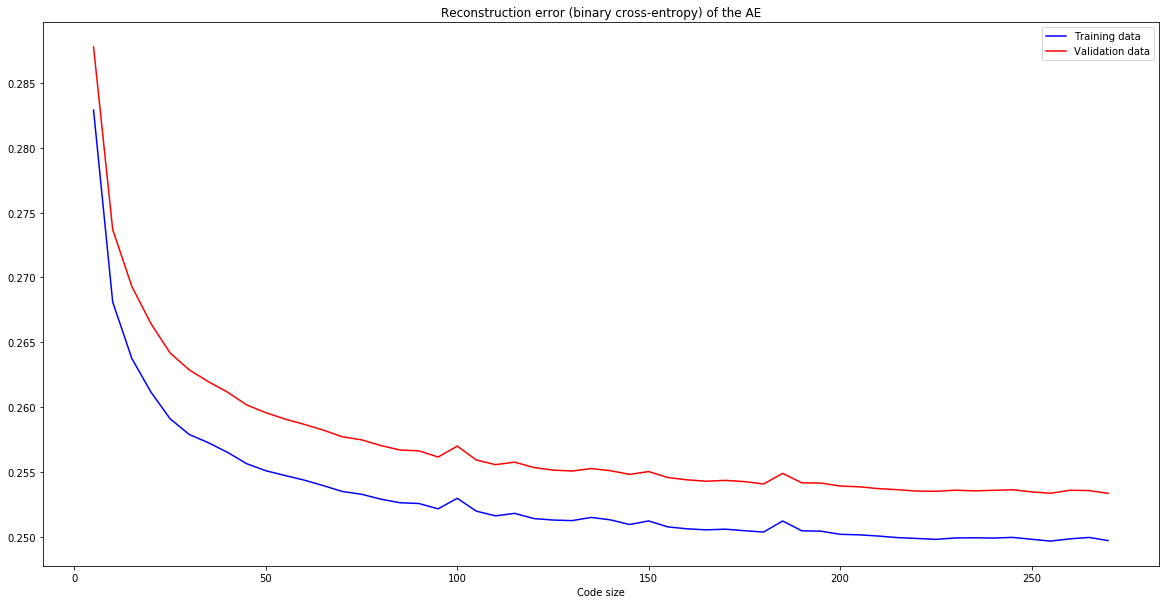

In [24]:
plt.figure(figsize=(20,10))
plt.plot(dimensions_5_270, training_errors_5_270, 'b')
plt.plot(dimensions_5_270, test_errors_5_270, 'r')
plt.legend(['Training data', 'Validation data'])
plt.xlabel('Code size')
plt.title('Reconstruction error (binary cross-entropy) of the AE')
plt.show()

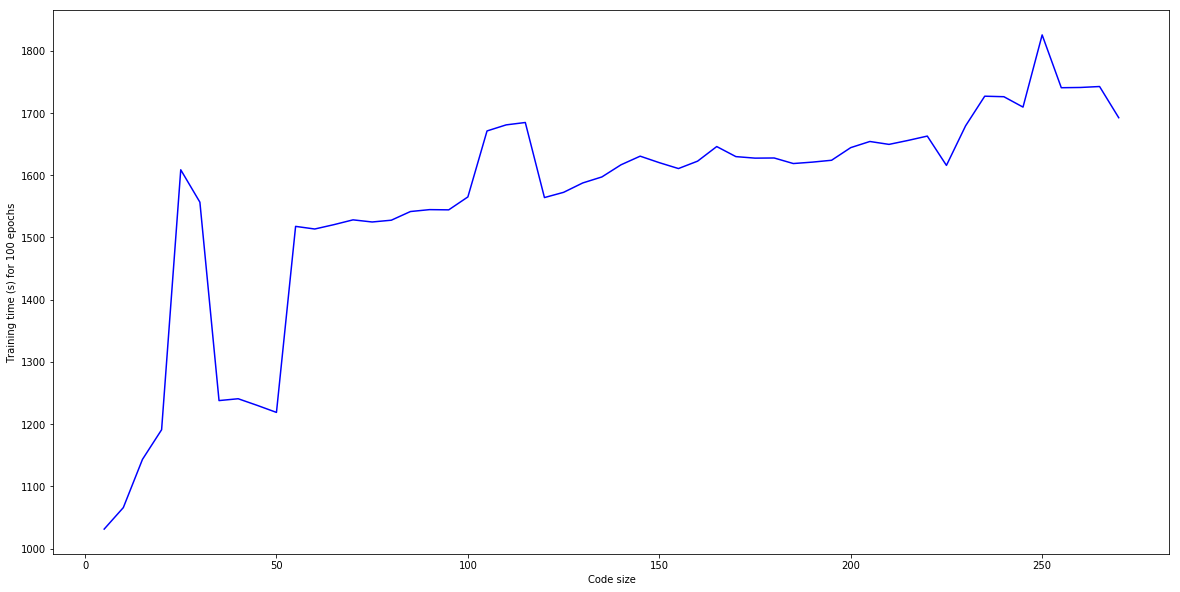

In [25]:
plt.figure(figsize=(20,10))
plt.plot(dimensions_5_270, training_times_5_270, 'b')
plt.xlabel('Code size')
plt.ylabel('Training time (s) for 100 epochs')
plt.show()

In [38]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_5.h5')
H_5 = encoder.predict(x_test[:10])
x_reconstruction_test_5 = decoder.predict(H_5) 
print('Code shape: ', H_5.shape)
print('Reconstruction shape: ', x_reconstruction_test_5.shape)

Code shape:  (10, 5)
Reconstruction shape:  (10, 28, 28, 1)


In [39]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')
H_100 = encoder.predict(x_test[:10])
x_reconstruction_test_100 = decoder.predict(H_100) 
print('Code shape: ', H_100.shape)
print('Reconstruction shape: ', x_reconstruction_test_100.shape)

Code shape:  (10, 100)
Reconstruction shape:  (10, 28, 28, 1)


In [40]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_200.h5')
H_200 = encoder.predict(x_test[:10])
x_reconstruction_test_200 = decoder.predict(H_200) 
print('Code shape: ', H_200.shape)
print('Reconstruction shape: ', x_reconstruction_test_200.shape)

Code shape:  (10, 200)
Reconstruction shape:  (10, 28, 28, 1)


In [41]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_50.h5')
H_50 = encoder.predict(x_test[:10])
x_reconstruction_test_50 = decoder.predict(H_50) 
print('Code shape: ', H_50.shape)
print('Reconstruction shape: ', x_reconstruction_test_50.shape)

Code shape:  (10, 50)
Reconstruction shape:  (10, 28, 28, 1)


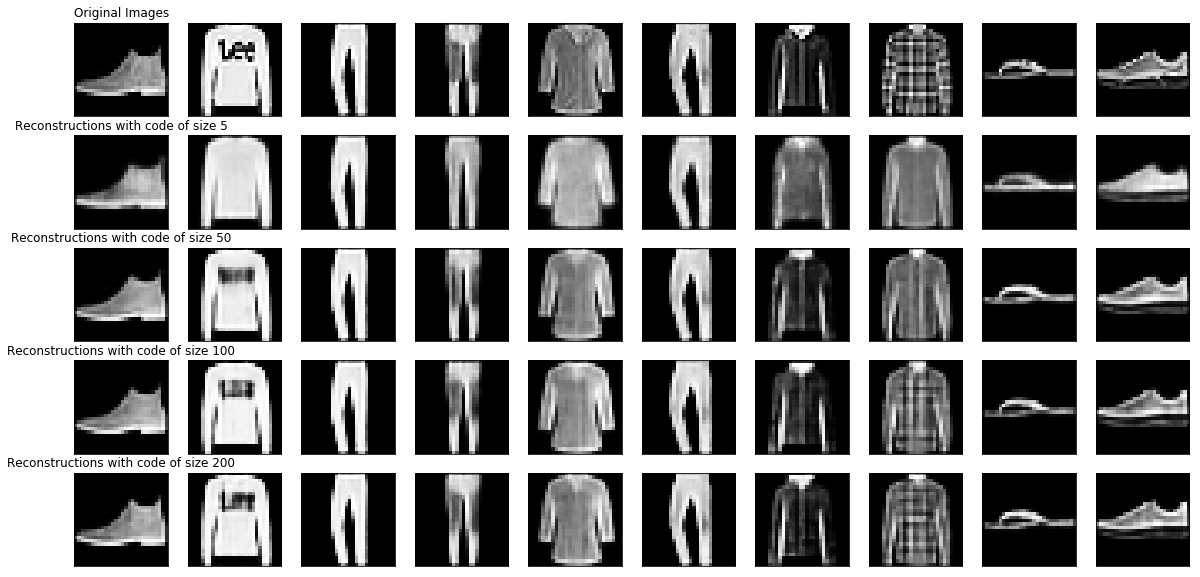

In [42]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Original Images')

    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(x_reconstruction_test_5[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions with code of size 5')
        
    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(x_reconstruction_test_50[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions with code of size 50')
        
    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(x_reconstruction_test_100[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions with code of size 100')
        
    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(x_reconstruction_test_200[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions with code of size 200')
        
plt.show()

### T-SNE

In [18]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 
print('Code shape: ', H.shape)
print('Reconstruction shape: ', x_reconstruction_test.shape)

Code shape:  (10000, 100)
Reconstruction shape:  (10000, 28, 28, 1)


In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
H_tsne = tsne.fit_transform(H[y_test==0])
H_tsne.shape
#plot_embedding(X_tsne, "Principal Components projection of the digits")
#plt.show()

(1000, 2)

In [22]:
from matplotlib import offsetbox

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 2e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            props=dict(boxstyle='round', edgecolor='white')
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(x_test[y_test==0][i,:,:,0], cmap=plt.cm.gray, zoom=1), X[i], bboxprops=props)
            ax.add_artist(imagebox)
    if title is not None:
        plt.title(title)

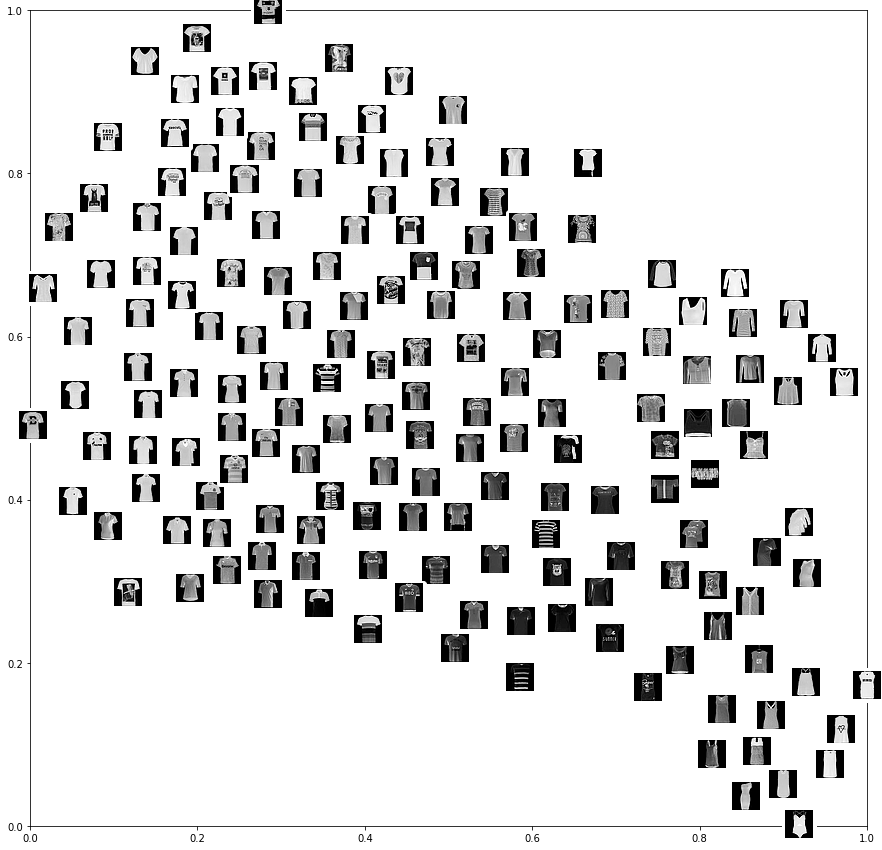

In [23]:
plot_embedding(H_tsne)
plt.show()

### Studying Linear Approximation

In [5]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_5.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

In [6]:
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))
W.shape

(5, 28, 28)

In [11]:
X_linear_approx_test = np.dot(H, W.reshape(W.shape[0], np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)
X_linear_approx_test.shape

(10000, 28, 28)

In [12]:
np.linalg.norm(x_reconstruction_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))

955.3753

In [19]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_5.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))
print("Basis images, shape: ", W.shape)
X_linear_approx_test = np.dot(H, W.reshape(W.shape[0], np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)
print("Linear approximation reconstruction, shape: ", X_linear_approx_test.shape)
er = np.linalg.norm(x_reconstruction_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between AE reconstruction and linear approximation reconstruction: ", er)
er = np.linalg.norm(x_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between x_test and linear approximation reconstruction: ", er)

Basis images, shape:  (5, 28, 28)
Linear approximation reconstruction, shape:  (10000, 28, 28)
Error between AE reconstruction and linear approximation reconstruction:  955.3753
Error between x_test and linear approximation reconstruction:  1029.5195


In [20]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))
print("Basis images, shape: ", W.shape)
X_linear_approx_test = np.dot(H, W.reshape(W.shape[0], np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)
print("Linear approximation reconstruction, shape: ", X_linear_approx_test.shape)
er = np.linalg.norm(x_reconstruction_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between AE reconstruction and linear approximation reconstruction: ", er)
er = np.linalg.norm(x_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between x_test and linear approximation reconstruction: ", er)

Basis images, shape:  (100, 28, 28)
Linear approximation reconstruction, shape:  (10000, 28, 28)
Error between AE reconstruction and linear approximation reconstruction:  315.66827
Error between x_test and linear approximation reconstruction:  342.91406


In [21]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_200.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))
print("Basis images, shape: ", W.shape)
X_linear_approx_test = np.dot(H, W.reshape(W.shape[0], np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)
print("Linear approximation reconstruction, shape: ", X_linear_approx_test.shape)
er = np.linalg.norm(x_reconstruction_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between AE reconstruction and linear approximation reconstruction: ", er)
er = np.linalg.norm(x_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between x_test and linear approximation reconstruction: ", er)

Basis images, shape:  (200, 28, 28)
Linear approximation reconstruction, shape:  (10000, 28, 28)
Error between AE reconstruction and linear approximation reconstruction:  235.39262
Error between x_test and linear approximation reconstruction:  263.6475


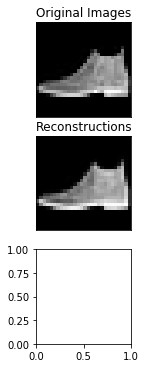

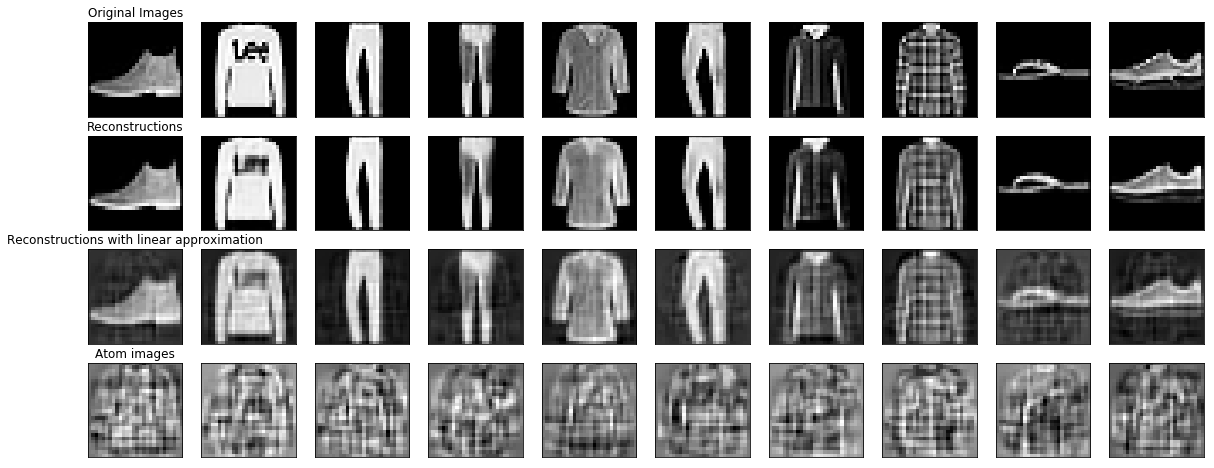

In [25]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Original Images')

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_reconstruction_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions')
        
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(X_linear_approx_test[i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Reconstructions with linear approximation')
        
    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(W[i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Atom images')
        
plt.show()

In [23]:
W.shape

(200, 28, 28)

### Activation Maximization

In [14]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_10.h5')

In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 1)                 6561473   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         6592449   
Total params: 13,153,922
Trainable params: 13,136,898
Non-trainable params: 17,024
_________________________________________________________________


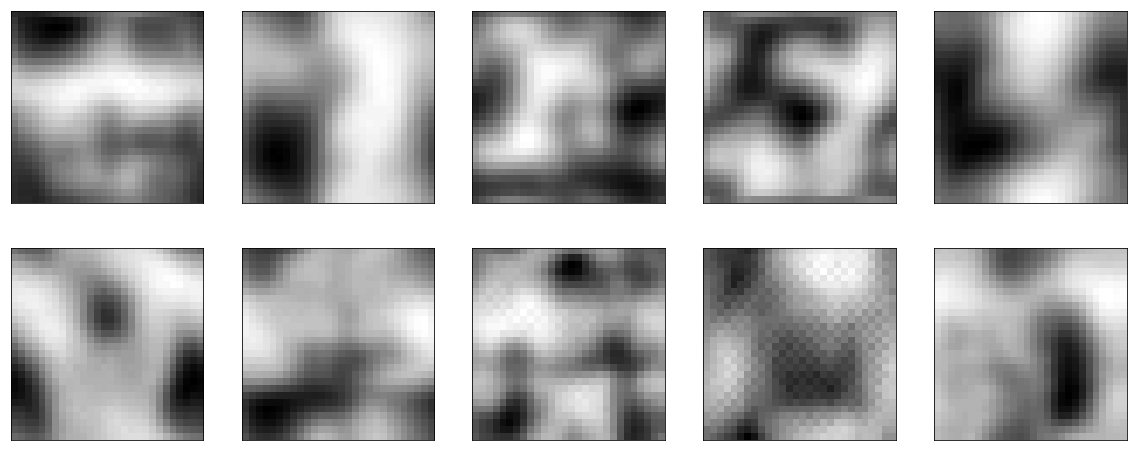

In [16]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i + 1)
    losses = [
        (ActivationMaximization(encoder.layers[10], [i]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]
    x_viz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses, input_modifiers=[Jitter()], seed_input= x_test[0])
    plt.imshow(x_viz[:,:,0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

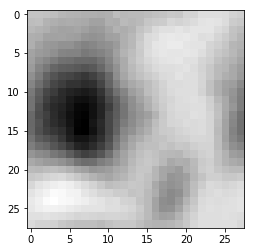

In [12]:
losses = [
        (ActivationMaximization(encoder.layers[10], [0]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]
x_viz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses, input_modifiers=[Jitter()], seed_input= x_test[0])
plt.imshow(x_viz[:,:,0], cmap='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [50]:
x_test.shape

(10000, 28, 28, 1)

In [12]:
vizX = visualize_activation(encoder, 10, filter_indices=[0])

AttributeError: Layer encoder has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

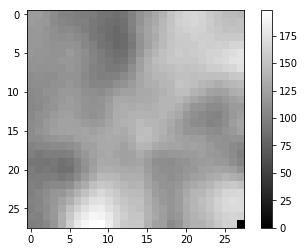

In [40]:
losses = [
        (ActivationMaximization(encoder.layers[10], [10]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]
Xviz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses)
plt.imshow(Xviz[:,:,0], cmap='gray')
plt.colorbar()
plt.show()

In [33]:
Xviz.shape

(28, 28, 1)

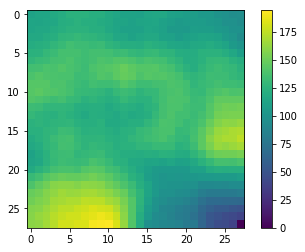

In [37]:
plt.imshow(Xviz[:,:,0])
plt.colorbar()
plt.show()

In [30]:
losses = [
        (ActivationMaximization(encoder.layers[10], [0]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]

In [22]:
encoder.get_input_at(0)

<tf.Tensor 'input_19_1:0' shape=(?, 28, 28, 1) dtype=float32>

In [23]:
encoder.get_input_at(1)

<tf.Tensor 'input_19:0' shape=(?, 28, 28, 1) dtype=float32>

In [11]:
encoder.layers[10]

In [62]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/NoBatchNorm/18_05_28_AEinfoGAN_100.h5')

In [63]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 100)               6658340   
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         6664385   
Total params: 13,322,725
Trainable params: 13,322,725
Non-trainable params: 0
_________________________________________________________________


### 2. Sparsity constraints

In [5]:
latent_dim = 100


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = Dense(latent_dim, activity_regularizer=regularizers.l1(10e-4))(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(1024)(encoded_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(6272)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((7,7,128))(x)
x = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
decoded = Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', activation='sigmoid')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 461s 8ms/step - loss: 3.4722 - val_loss: 2.1292
Epoch 2/2
60000/60000 [==============================] - 480s 8ms/step - loss: 0.8700 - val_loss: 2.3751


In [7]:
x_train, y_train = mnist_reader.load_mnist(FILE_PATH + 'fashion_mnist/data/fashion', kind='train')
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format


### Trying shallow AE

In [4]:
latent_dim = 5


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Flatten()(input_img)
encoded = Dense(latent_dim)(x)

encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(28*28)(encoded_img)
decoded = Reshape((28,28,1))(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3925      
Total params: 3,925
Trainable params: 3,925
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               4704      
_________________________________________________________________
reshape_

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 112us/step - loss: 1.2585 - val_loss: 1.0349
Epoch 2/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.8706 - val_loss: 0.7574
Epoch 3/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.6696 - val_loss: 0.5902
Epoch 4/100
60000/60000 [==============================] - 6s 100us/step - loss: 0.4898 - val_loss: 0.4508
Epoch 5/100
60000/60000 [==============================] - 5s 88us/step - loss: 0.4264 - val_loss: 0.4181
Epoch 6/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.3831 - val_loss: 0.3712
Epoch 7/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.3592 - val_loss: 0.3522
Epoch 8/100
60000/60000 [==============================] - 6s 101us/step - loss: 0.3518 - val_loss: 0.3517
Epoch 9/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.3509 - val_los

In [13]:
#autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_5.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 
W = np.dot(np.linalg.pinv(H), x_test.reshape((x_test.shape[0], img_rows*img_cols)))
W = W.reshape((W.shape[0], img_rows, img_cols))
print("Basis images, shape: ", W.shape)
X_linear_approx_test = np.dot(H, W.reshape(W.shape[0], np.prod(W.shape[1:])))
X_linear_approx_test= X_linear_approx_test.reshape(len(x_test),img_rows, img_cols)
print("Linear approximation reconstruction, shape: ", X_linear_approx_test.shape)
er = np.linalg.norm(x_reconstruction_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between AE reconstruction and linear approximation reconstruction: ", er)
er = np.linalg.norm(x_test.reshape((10000, 28*28)) - X_linear_approx_test.reshape((10000, 28*28)))
print("Error between x_test and linear approximation reconstruction: ", er)

Basis images, shape:  (5, 28, 28)
Linear approximation reconstruction, shape:  (10000, 28, 28)
Error between AE reconstruction and linear approximation reconstruction:  496.17914
Error between x_test and linear approximation reconstruction:  543.2101


In [9]:
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

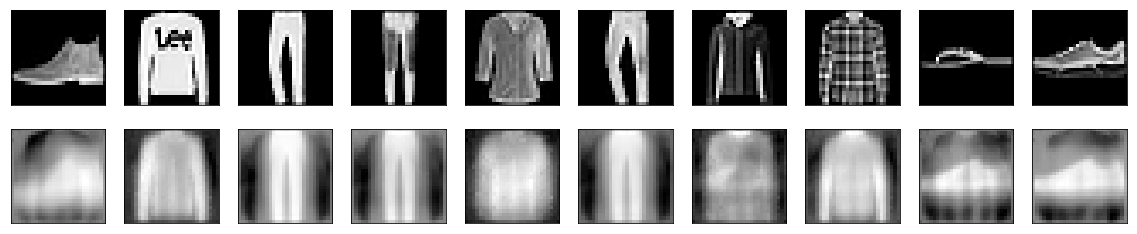

In [10]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstruction_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
plt.show()

### Replacing RELU by lRELU in decoder

In [9]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')
H_RELU = encoder.predict(x_test_small)
x_reconstruction_test_RELU = decoder.predict(H_RELU) 

In [10]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/lRELUdecoder/18_06_06_AEinfoGAN_100.h5')
H_lRELU = encoder.predict(x_test_small)
x_reconstruction_test_lRELU = decoder.predict(H_lRELU) 

In [11]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/lRELUdecoderSigmoid/18_06_06_AEinfoGAN_100.h5')
H_lRELU_sigmoid = encoder.predict(x_test_small)
x_reconstruction_test_lRELU_sigmoid = decoder.predict(H_lRELU_sigmoid) 

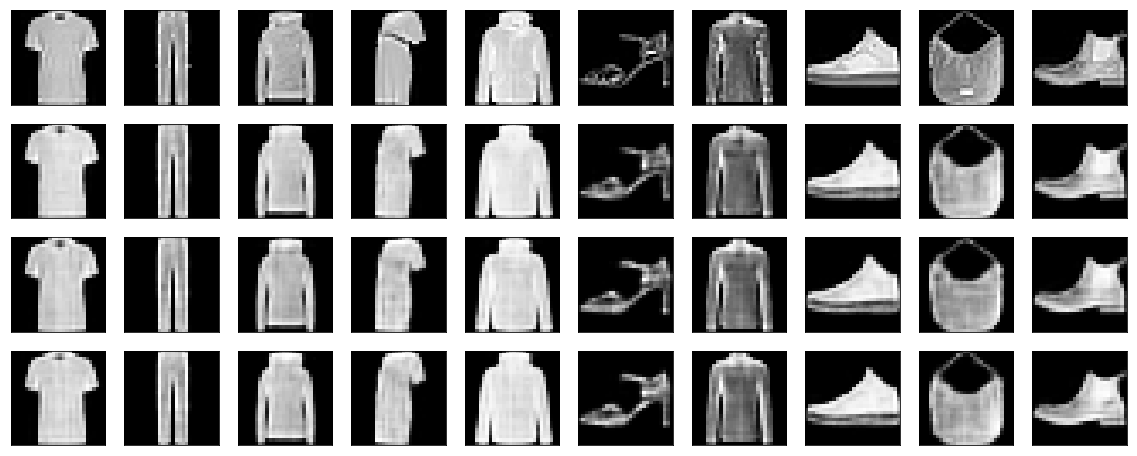

In [12]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test_small[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display RELU reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_reconstruction_test_RELU[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
    # display lRELU reconstruction
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(x_reconstruction_test_lRELU[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    

    # display lRELU + sigmoid reconstruction
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(x_reconstruction_test_lRELU_sigmoid[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    

plt.show()

### 2. Sparsity Constraints

Keeping the architecture with a sigmoid activation at the end of the encoder and lRELU activations in the decoder. We tried the l1 activity regularization constraint (with a weight of 10e-5)of the Keras library.

In [48]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Sparse/Models/activity_reg/18_06_07_AEinfoGAN_100.h5')
H_sparse = encoder.predict(x_test_small)
x_reconstruction_test_sparse = decoder.predict(H_sparse) 

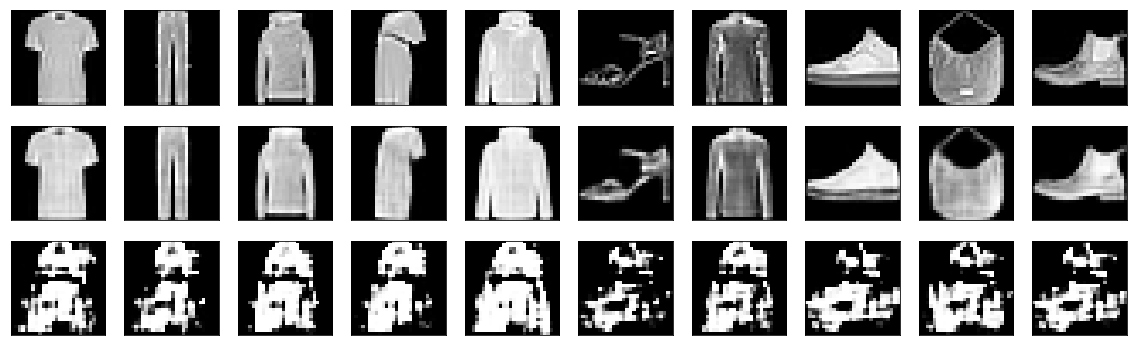

In [14]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_small[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    # display non sparse
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_reconstruction_test_lRELU_sigmoid[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    
    # display sparse
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_reconstruction_test_sparse[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)        

plt.show()

In [15]:
H_sparse.shape

(10, 100)

In [51]:
H_sparse = encoder.predict(x_test)
x_reconstruction_test_sparse = decoder.predict(H_sparse) 

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
H_tsne = tsne.fit_transform(H_sparse)
H_tsne.shape

(10000, 2)

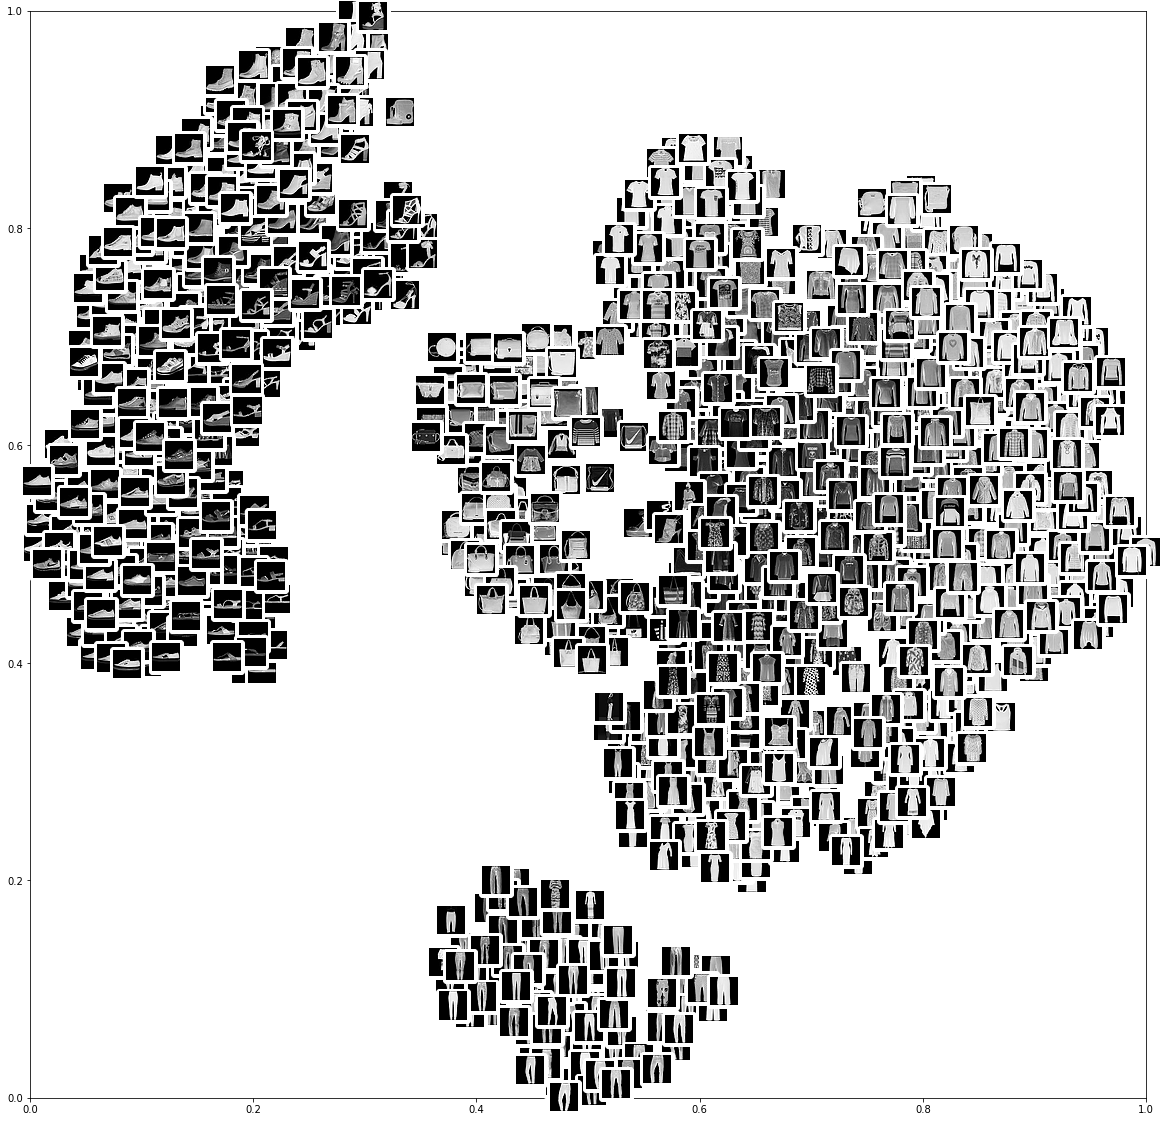

In [22]:
plot_embedding(H_tsne)
plt.show()

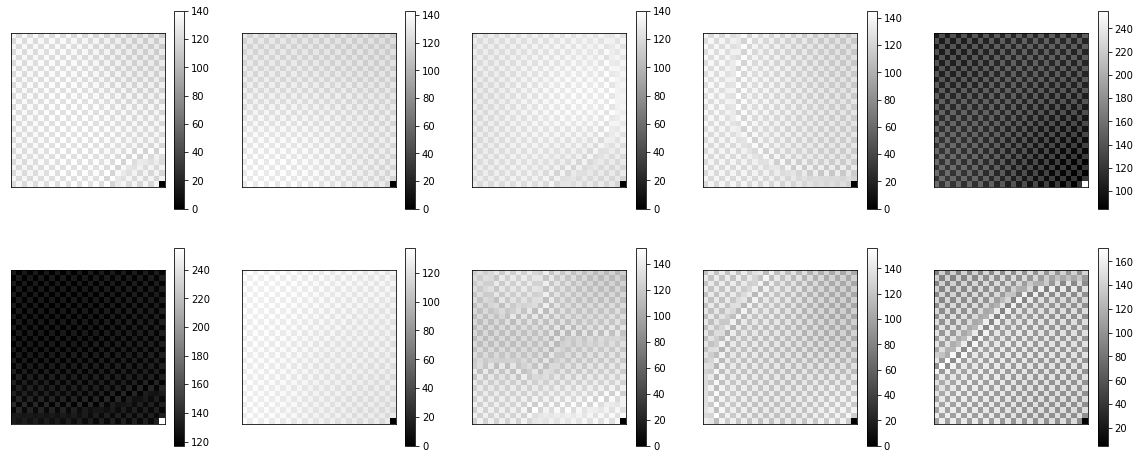

In [45]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i + 1)
    losses = [
        (ActivationMaximization(encoder.layers[10], [50+i]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]
    x_viz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses)
    plt.imshow(x_viz[:,:,0], cmap='gray')
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
plt.show()

In [50]:
losses = [
        (ActivationMaximization(encoder.layers[10], [5]), 1),
        (LPNorm(encoder.get_input_at(0)), 10),
        (TotalVariation(encoder.get_input_at(0)), 10)
    ]
x_viz = visualize_activation_with_losses(encoder.get_input_at(0), losses=losses, verbose=True)
plt.imshow(x_viz[:,:,0], cmap='gray')

Iteration: 1, named_losses: <zip object at 0x7f53ef85eb48>, overall loss: 6099.0048828125
Iteration: 2, named_losses: <zip object at 0x7f53ef84ce08>, overall loss: 2990.861328125
Iteration: 3, named_losses: <zip object at 0x7f53ef8bc308>, overall loss: 1566.1395263671875
Iteration: 4, named_losses: <zip object at 0x7f53ef8845c8>, overall loss: 809.30712890625
Iteration: 5, named_losses: <zip object at 0x7f53ef93a7c8>, overall loss: 406.2795104980469
Iteration: 6, named_losses: <zip object at 0x7f53ef802948>, overall loss: 217.83645629882812
Iteration: 7, named_losses: <zip object at 0x7f53ef8845c8>, overall loss: 161.7711181640625
Iteration: 8, named_losses: <zip object at 0x7f53ef927608>, overall loss: 113.4239273071289
Iteration: 9, named_losses: <zip object at 0x7f53ef8bc308>, overall loss: 91.68222045898438
Iteration: 10, named_losses: <zip object at 0x7f53ef927c48>, overall loss: 70.58694458007812
Iteration: 11, named_losses: <zip object at 0x7f53ef8aaf88>, overall loss: 60.611076

Iteration: 103, named_losses: <zip object at 0x7f53ef7d7b08>, overall loss: 23.341854095458984
Iteration: 104, named_losses: <zip object at 0x7f53ef964dc8>, overall loss: 23.411853790283203
Iteration: 105, named_losses: <zip object at 0x7f53ef9fb148>, overall loss: 23.29233741760254
Iteration: 106, named_losses: <zip object at 0x7f53ef9051c8>, overall loss: 23.379467010498047
Iteration: 107, named_losses: <zip object at 0x7f53ef8bc6c8>, overall loss: 23.286537170410156
Iteration: 108, named_losses: <zip object at 0x7f53ef8845c8>, overall loss: 23.397369384765625
Iteration: 109, named_losses: <zip object at 0x7f53ef9542c8>, overall loss: 23.303054809570312
Iteration: 110, named_losses: <zip object at 0x7f53ef916f48>, overall loss: 23.395286560058594
Iteration: 111, named_losses: <zip object at 0x7f53ef927c48>, overall loss: 23.28415298461914
Iteration: 112, named_losses: <zip object at 0x7f53ef7d7788>, overall loss: 23.37295150756836
Iteration: 113, named_losses: <zip object at 0x7f53ef

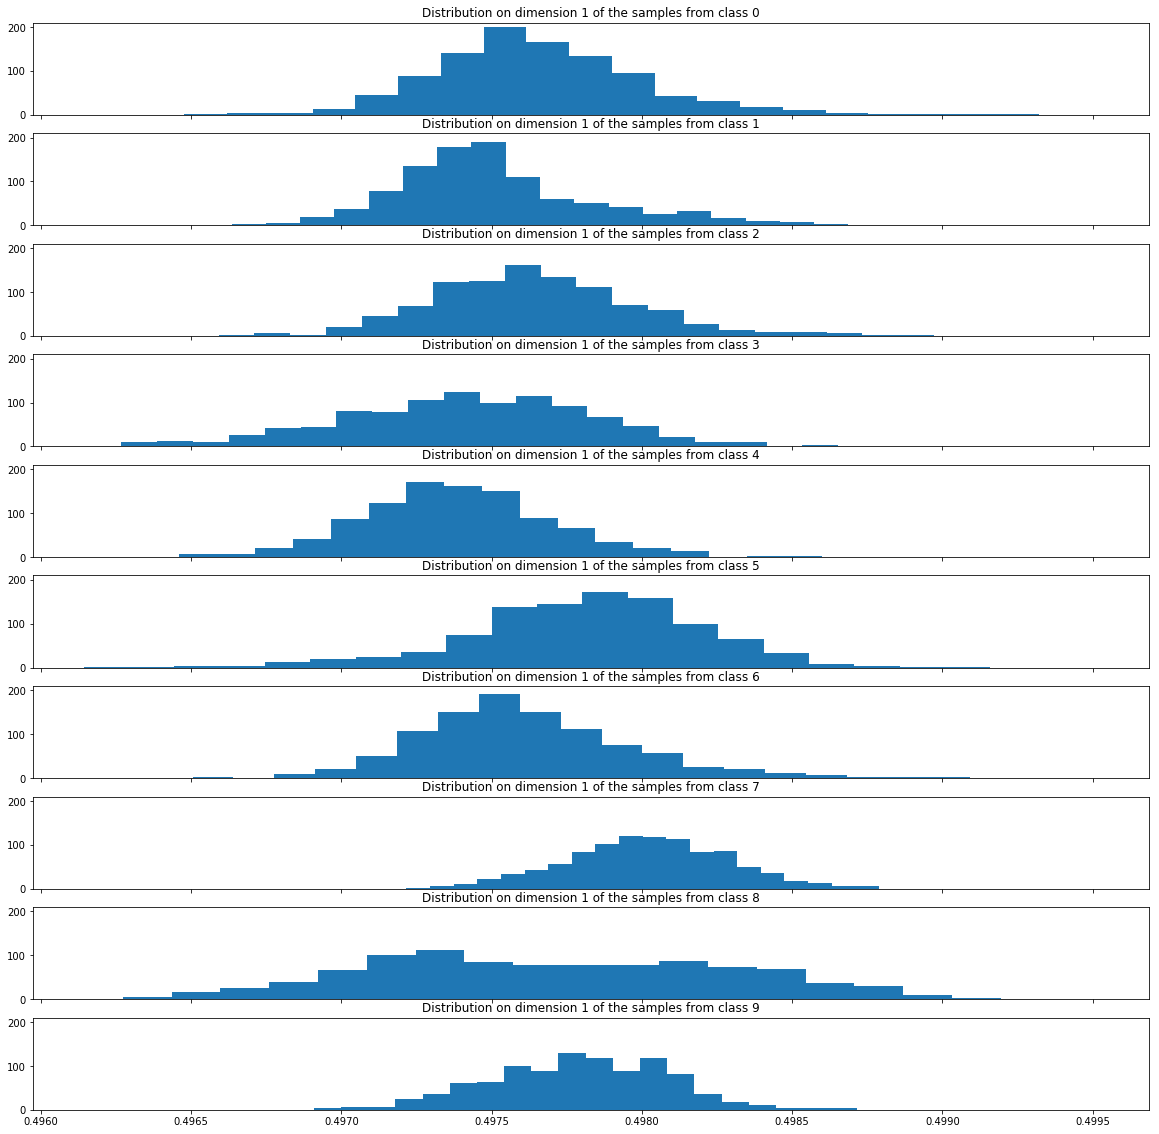

In [53]:
fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, figsize=(20,20))
for i in range(10):
    axs[i].hist(H_sparse[y_test==i,10], bins=20)
    axs[i].set_title('Distribution on dimension 1 of the samples from class '+str(i))
plt.show()

In [55]:
print('Minimum of each code dimension: ', np.min(H_sparse, axis=0), '\n')
print('Maximum of each code dimension: ', np.max(H_sparse, axis=0), '\n')
print('Mean of each code dimension: ', np.mean(H_sparse, axis=0), '\n')
print('Std of each code dimension: ', np.std(H_sparse, axis=0), '\n')

Minimum of each code dimension:  [0.49892715 0.49757484 0.49977413 0.49866858 0.5001124  0.4985162
 0.4987781  0.4976949  0.49898794 0.4983456  0.49614316 0.49920708
 0.4984122  0.497854   0.49855247 0.49797133 0.49654996 0.4979582
 0.497155   0.497595   0.49934432 0.49664745 0.4973077  0.49839032
 0.4971741  0.49516383 0.49816167 0.49876827 0.49844155 0.49751675
 0.49814534 0.499708   0.49964347 0.49855727 0.4959323  0.5006855
 0.49803934 0.49778953 0.49879187 0.4960457  0.49794537 0.49904385
 0.49921444 0.49869925 0.49811766 0.4985265  0.49849844 0.4978108
 0.49881396 0.49452507 0.49923393 0.50146294 0.49921256 0.49814144
 0.49928054 0.4987177  0.4987346  0.49742234 0.49706224 0.49640018
 0.49637333 0.49901038 0.49758214 0.49881935 0.50001657 0.49762642
 0.49871537 0.49800172 0.5000269  0.49727714 0.49785134 0.4989674
 0.5010991  0.49969745 0.49842635 0.49731714 0.4989115  0.49839067
 0.4987013  0.49720806 0.49718514 0.4990731  0.5007477  0.49750063
 0.4999926  0.49907568 0.49741527 

In [56]:
print('Minimum along all dimensions: ', np.min(H_sparse), '\n')
print('Maximum along all dimensions: ', np.max(H_sparse), '\n')
print('Mean along dimensions: ', np.mean(H_sparse), '\n')
print('Std along all dimension: ', np.std(H_sparse), '\n')

Minimum along all dimensions:  0.49452507 

Maximum along all dimensions:  0.5047871 

Mean along dimensions:  0.50006795 

Std along all dimension:  0.0012955745 



### Sparsity with KL divergence

In [14]:
from keras.regularizers import l2, Regularizer
import keras.backend as K

def kl_divergence(output):
    s_hat = K.mean(output, 0)
    s = 0.01
    s_hat += 10 ** -5
    val = s * K.log(s/s_hat) + (1 - s) * K.log((1 - s)/(1 - s_hat))
    return val


class SparsityRegularizer(Regularizer):
    def __init__(self, kl_coef=0.01, sparsity_param=0.05):
        self.coef = K.cast_to_floatx(kl_coef)
        self.target_sparsity = K.cast_to_floatx(sparsity_param)
        self.uses_learning_phase = True

    def __call__(self, loss):
        if not hasattr(self, 'layer'):
            raise Exception('Need to call `set_layer` on '
                            'SparsityRegularizer instance '
                            'before calling the instance.')
        regularized_loss = loss
        for i in range(len(self.layer.inbound_nodes)):
            output = self.layer.get_output_at(i)
            regularized_loss += self.coef * K.sum(kl_divergence(K.mean(output, 0), self.target_sparsity))
        return K.in_train_phase(regularized_loss, loss)

    def get_config(self):
        return {'name' : self.__class__.__name__,
                'coef' : self.coef,
                'sparsity_param' : self.target_sparsity}

def sparse(l=0.01):
    return SparsityRegularizer(sparsity_param=l)

In [18]:
latent_dim = 10


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = Dense(latent_dim, activation = 'sigmoid', activity_regularizer=kl_divergence)(x)


encoder = Model(input_img, encoded, name='encoder')
encoder.summary()

encoded_img = Input(shape=(latent_dim,))  # adapt this if using `channels_first` image data format

x = Dense(1024)(encoded_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(6272)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Reshape((7,7,128))(x)
x = Conv2DTranspose(64, (4, 4), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
decoded = Conv2DTranspose(1, (4, 4), strides=(2,2), padding='same', activation='sigmoid')(x)

decoder = Model(encoded_img, decoded, name='decoder')
decoder.summary()

encoded = encoder(input_img)
decoded = decoder(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
__________

In [19]:
autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 466s 8ms/step - loss: 0.3517 - val_loss: 0.3212
Epoch 2/2
60000/60000 [==============================] - 473s 8ms/step - loss: 0.3042 - val_loss: 0.3113


### Classifier performance

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
autoencoder, encoder, decoder = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_100.h5')
H = encoder.predict(x_test)
x_reconstruction_test = decoder.predict(H) 

In [7]:
idx = np.array(range(H.shape[0]))

In [ ]:
H_train=H[idx][:9000]
y_test

In [5]:
def score(y_true, y_pred):
    return np.mean(y_true==y_pred)

In [6]:
def crossVal(H):
    scores = np.zeros(10)
    for i in range(10):
        idx = np.array(range(H.shape[0]))
        np.random.shuffle(idx)
        H_train=H[idx][:9000]
        y_Htrain = y_test[idx][:9000]
        H_test=H[idx][9000:]
        y_Htest = y_test[idx][9000:]
        clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0)
        clf.fit(H_train, y_Htrain)
        y_Hpred = clf.predict(H_test)
        scores[i]=score(y_Htest, y_Hpred)
    return np.mean(scores)
        

In [23]:
crossVal(H)

0.5587

In [7]:
dims = [1] + [i*5 for i in range(1,10)] + [i*10 for i in range(5, 28)] + [i*50 for i in range(6, 11)]

In [ ]:
classification_scores = np.zeros(len(dims))
for i,d in enumerate(dims):
    print(d)
    _, encoder, _ = load_AE('/home/bastien/Documents/StageCMM/Auto-encoders/AEinfoGAN/Simple/Models/18_05_22_AEisoGAN_' + str(d) + '.h5')
    H = encoder.predict(x_test)
    classification_scores[i] = crossVal(H)
    np.save('./classification_scores.npy', classification_scores)

1
5
10
15
20
25


In [11]:
print(classification_scores)

[0.5696 0.7958 0.8161 0.8063 0.8106 0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.    ]


In [3]:
classification_scores=np.load('../testClassifier/classification_scores.npy')
classification_dims=np.load('../testClassifier/dimensions.npy')

In [5]:
classification_scores

array([0.564 , 0.7979, 0.818 , 0.8002, 0.8049, 0.805 , 0.8084, 0.8097,
       0.8041, 0.8095, 0.8036, 0.8102, 0.7957, 0.8028, 0.802 , 0.7999,
       0.7934, 0.7948, 0.7938, 0.7977, 0.7933, 0.7918, 0.7971, 0.7917,
       0.7912, 0.7917, 0.7924, 0.7891, 0.789 , 0.7919, 0.7922, 0.7873,
       0.7931, 0.7989, 0.7876, 0.7866, 0.7893, 0.7989])

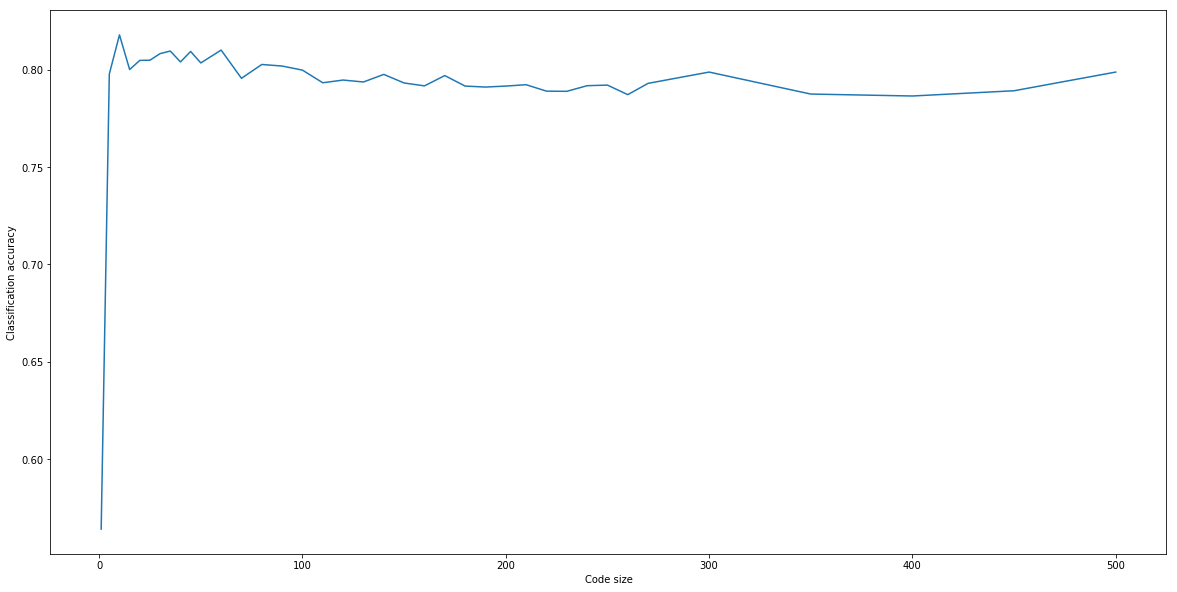

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(classification_dims, classification_scores)
plt.xlabel('Code size')
plt.ylabel('Classification accuracy')
plt.show()